In [1]:
import numpy as np
import pandas as pd 
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder


In [2]:
directories = {
    'dislocation': '/kaggle/input/chestpelviscspinescans/c-spine_dislocation',
    'fracture': '/kaggle/input/chestpelviscspinescans/c-spine_fracture',
    'normal': '/kaggle/input/chestpelviscspinescans/c-spine_normal',
}

# Load and shuffle image paths and labels
image_paths = []
labels = []
for category, directory_path in directories.items():
    image_files = [file for file in os.listdir(directory_path) if file.lower().endswith(('.jpg', '.jpeg'))]
    image_paths.extend([os.path.join(directory_path, file) for file in image_files])
    labels.extend([category] * len(image_files))

In [3]:

import numpy as np
import os
from PIL import Image


indices = np.arange(len(image_paths))
np.random.shuffle(indices)

shuffled_image_paths = []
shuffled_labels = []

for index in indices:
    image_path = image_paths[index]
    label = labels[index]

    try:
        image = Image.open(image_path)
        image = image.resize((224, 224), Image.BILINEAR)
        image_array = np.array(image)

        shuffled_image_paths.append(image_array)
        shuffled_labels.append(label)
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")

X_shuffled = np.array(shuffled_image_paths)
Y_shuffled = np.array(shuffled_labels)


Error processing D:\MachineLearning\GraduationProject\Spine2data\c-spine_normal\img-00088-00001 (4th copy).jpg: image file is truncated (34 bytes not processed)


In [4]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X_shuffled, Y_shuffled, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [5]:
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_val_encoded = label_encoder.transform(Y_val)
Y_test_encoded = label_encoder.transform(Y_test)

In [6]:
image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [7]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)



9406464/9406464 [==============================] - 0s 0us/step


In [8]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)





In [9]:
history = model.fit(
    image_generator.flow(X_train, Y_train_encoded, batch_size=32),
    validation_data=image_generator.flow(X_val, Y_val_encoded),
    epochs=7,
)

Epoch 1/7
50/50 [==============================] - 29s 392ms/step - loss: 0.6693 - accuracy: 0.7387 - val_loss: 0.3784 - val_accuracy: 0.8442
Epoch 2/7
50/50 [==============================] - 18s 360ms/step - loss: 0.2229 - accuracy: 0.9290 - val_loss: 0.2318 - val_accuracy: 0.9246
Epoch 3/7
50/50 [==============================] - 17s 348ms/step - loss: 0.1806 - accuracy: 0.9340 - val_loss: 0.2069 - val_accuracy: 0.9347
Epoch 4/7
50/50 [==============================] - 19s 372ms/step - loss: 0.0989 - accuracy: 0.9667 - val_loss: 0.1068 - val_accuracy: 0.9749
Epoch 5/7
50/50 [==============================] - 19s 375ms/step - loss: 0.0794 - accuracy: 0.9698 - val_loss: 0.0612 - val_accuracy: 0.9799
Epoch 6/7
50/50 [==============================] - 18s 357ms/step - loss: 0.0503 - accuracy: 0.9830 - val_loss: 0.0346 - val_accuracy: 0.9950
Epoch 7/7
50/50 [==============================] - 18s 370ms/step - loss: 0.0449 - accuracy: 0.9856 - val_loss: 0.0475 - val_accuracy: 0.9950


In [10]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test_encoded)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

7/7 [==============================] - 0s 29ms/step - loss: 0.0320 - accuracy: 0.9950
Test Accuracy: 99.50%


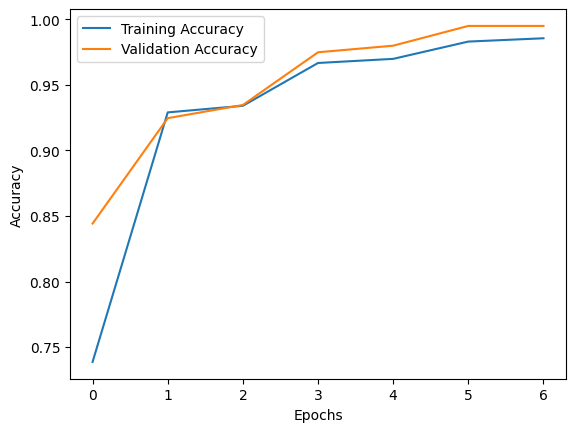

In [11]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

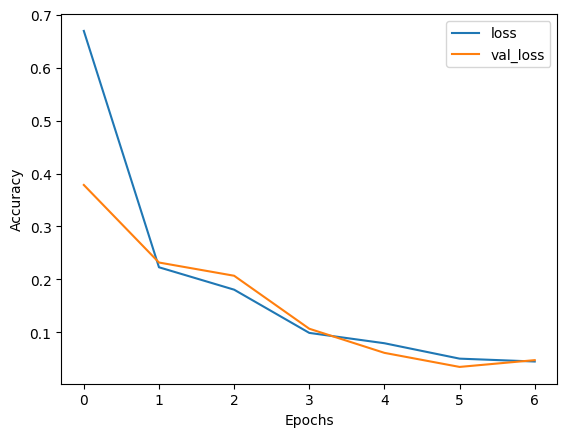

In [12]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [7]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


7/7 [==============================] - 6s 675ms/step


In [8]:
Y_test_original = label_encoder.inverse_transform(Y_test_encoded)
Y_pred_original = label_encoder.inverse_transform(y_pred_classes)

In [15]:
from sklearn.metrics import classification_report
report = classification_report(Y_test_original, Y_pred_original)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

 dislocation       0.98      1.00      0.99        49
    fracture       1.00      1.00      1.00        83
      normal       1.00      0.99      0.99        67

    accuracy                           0.99       199
   macro avg       0.99      1.00      0.99       199
weighted avg       1.00      0.99      0.99       199



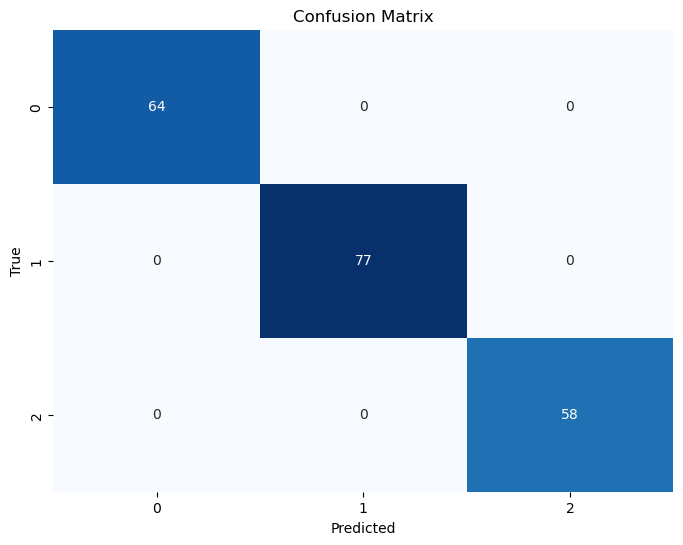

In [9]:
from sklearn.metrics import  confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusion = confusion_matrix(Y_test_original, Y_pred_original)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

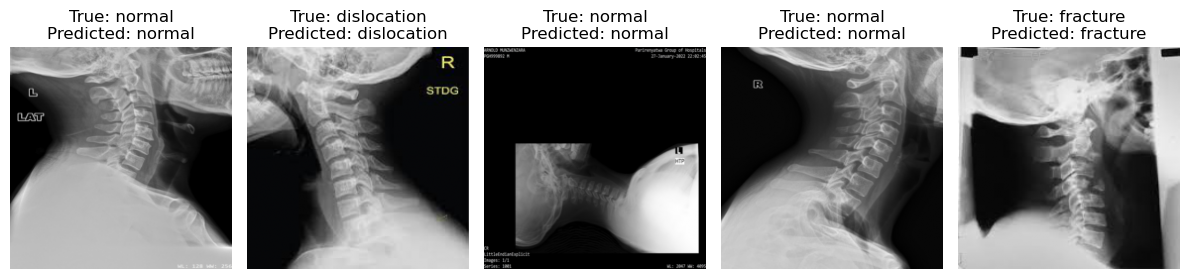

In [10]:
num_images_to_display = 5  
plt.figure(figsize=(12, 8))
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(X_test[i])
    plt.title(f'True: {Y_test_original[i]}\nPredicted: {Y_pred_original[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [18]:
model_filename = "Spine2.h5"
model.save(model_filename)

print(f"Model saved as {model_filename}")

Model saved as Spine2.h5


In [6]:
model = tf.keras.models.load_model("Spine2.h5")


In [11]:
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
import tensorflow as tf
def compute_gradcam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]

    output = conv_output[0]
    grads = tape.gradient(loss, conv_output)[0]

    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, output), axis=-1)
    
    cam = cv2.resize(cam.numpy(), (img_array.shape[1], img_array.shape[2]))
    cam = np.maximum(cam, 0)
    cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize to [0, 1]

    return cam 

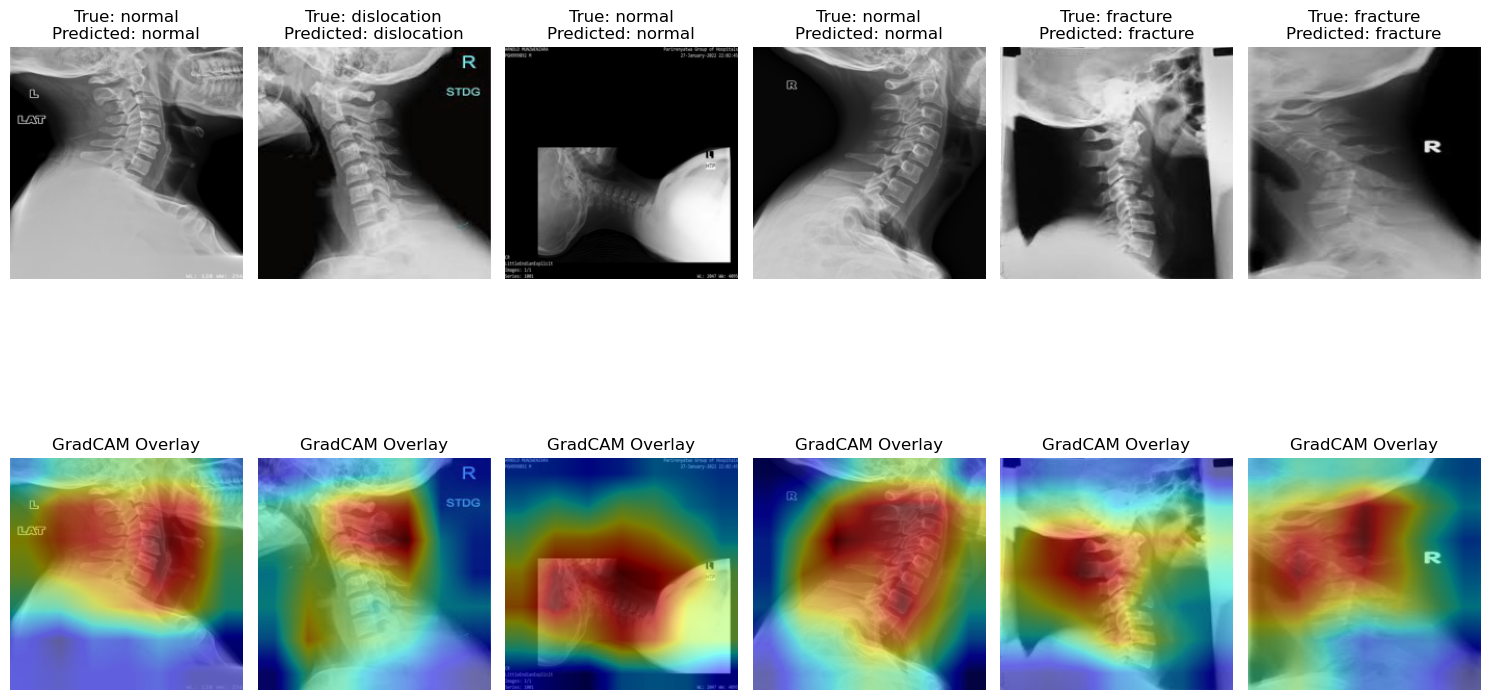

In [12]:
layer_name = 'Conv_1'
num_images_to_display = 6  

plt.figure(figsize=(15, 10))
for i in range(num_images_to_display):
    img = X_test[i]

    img = (img * 255).astype(np.uint8)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

    img_array = preprocess_input(np.expand_dims(img, axis=0))  
    cam = compute_gradcam(model, img_array, layer_name)

    cam = (cam - cam.min()) / (cam.max() - cam.min())

    plt.subplot(2, num_images_to_display, i + 1)
    plt.imshow(img, cmap='viridis')  
    plt.title(f'True: {Y_test_original[i]}\nPredicted: {Y_pred_original[i]}')
    plt.axis('off')

    plt.subplot(2, num_images_to_display, i + num_images_to_display + 1)
    plt.imshow(img, cmap='viridis')  
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title('GradCAM Overlay')
    plt.axis('off')

plt.tight_layout()
plt.show()